In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import mir_eval.sonify
import pandas as pd

In [153]:
class Drums:
    def __init__(self, file):
        self.file = file
        self.y, self.sr = librosa.load(self.file) #load audio: y = time series, sr = sampling rate

    #play audio
    def play(self): 
        return(Audio(data = self.y, rate = self.sr))
    
    #get tempo & beats
    def tempo(self):
        tempo, beat_frames = librosa.beat.beat_track(y = self.y, sr = self.sr)
        y_beats = librosa.clicks(frames=beat_frames, sr = self.sr)
        return(tempo, beat_frames, y_beats)
    
    #mel spectrogram & onsets/beats plot
    def melspec(self, xlim): #xlim = [n, n] timespan for plots
        S = librosa.feature.melspectrogram(y = self.y, sr = self.sr)
        
        #onset strength and times
        beat_frames = self.tempo()[1]
        o_env = librosa.onset.onset_strength(y=self.y, sr=self.sr)
        times = librosa.times_like(o_env, sr=self.sr)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=self.sr)

        #figures
        fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)
        ax.set(xlim=xlim, title='Mel Spec Snippet')
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         x_axis='time', y_axis='mel', ax=ax)
        ax2.plot(times, o_env, label='Sample Onset strength')
        ax2.vlines(times[beat_frames], 0, o_env.max(), color='black', alpha=0.9,
           linestyle='-', label='Beats')
        ax2.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
        ax2.legend()
        ax.label_outer()
        
        return(S)
    
    #save mel spec to csv
    def melcsv(self):
        S = self.melspec()
        np.savetxt("testmelspec.csv", S, delimiter=",") #save as csv
    
    #chromagram
    def chroma(self, xlim):
        Sc = np.abs(librosa.stft(self.y, n_fft=4096))**2
        chroma = librosa.feature.chroma_stft(S=Sc, sr=self.sr)

        fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)
        ax.set(xlim=xlim, title = 'Chromagram Snippet')
        img = librosa.display.specshow(librosa.amplitude_to_db(Sc, ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
        fig.colorbar(img, ax=[ax])
        ax.label_outer()
        img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax2)
        fig.colorbar(img, ax=[ax2])

tempo: 172 bpm


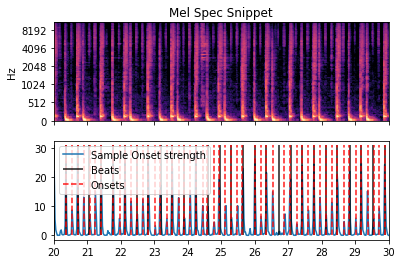

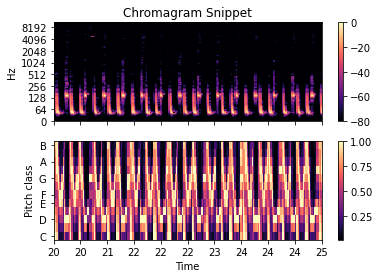

In [155]:
test = Drums(file)
test.play() 
print(f"tempo: {round(test.tempo()[0])} bpm")
test.melspec([20, 30])
test.chroma([20, 25])